Libraries & Parameters

In [1]:
!pip install -q awswrangler

import awswrangler as wr
import pandas as pd

import boto3
import pytz

import numpy as np
!pip install -U -q seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from sagemaker import get_execution_role

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [2]:
# Get Sagemaker Role
role = get_execution_role()
print(role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210503T205912 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::506926764659:role/service-role/AmazonSageMaker-ExecutionRole-20210503T205912


Runtime Parameters

In [3]:
airline_to_run = 'MQ'

___
# 1.) Download Data

## S3 parameters

In [4]:
# Flight data from Sagemaker Data Wrangler
bucket = 'sagemaker-us-west-2-506926764659/export-flow-05-16-30-08-0c003aed/output/data-wrangler-flow-processing-05-16-30-08-0c003aed/b98f4f8c-ddaf-4ee1-99da-b0dd09f47a21/default'
filename = 'part-00000-92fade68-00c4-41b3-9182-593084da2eae-c000.csv'
path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from entire year of 2011
# bucket = 'from-public-data/carrier-perf/transformed'
# filename = 'airOT2011all.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)

# # Flight data from 2011_01 
# bucket = 'from-public-data/carrier-perf/transformed/airOT2011'
# filename = 'airOT201101.csv'
# path_to_file = 's3://{}/{}'.format(bucket, filename)


# ________________________________________________________________
# Supporting dataset useful for EDA and understanding data
#   - airport codes
#   - airline codes
bucket2 = 'from-public-data/carrier-perf/raw'
file_airport = 'airports.csv'
file_airline = 'airlines.csv'

path_to_file_airport = 's3://{}/{}'.format(bucket2, file_airport)
path_to_file_airline = 's3://{}/{}'.format(bucket2, file_airline)

=== === === === ===
## Download data from S3

### 1. Flights Performance dataset

In [5]:
df = wr.s3.read_csv([path_to_file])
# df

A whopping 7,294,649 rows (records) of JUST year 2007!  Thanks to all the Sagemaker Data Wrangler, I was able to already do some data cleaning and adjustment:
  - Create new variable `late_flight` depending on `DEP_DELAY`
  - Trim value to remove outliers for `DEP_DLAY`
  - Drop records for Cancelled flights `CANCELED` == 1 (doesn't make much sense to have flights that's irrelevant to flights delay when flight never occur)

### 2. Airports & Airlines dataset

In [6]:
df_airports = wr.s3.read_csv([path_to_file_airport])
df_airlines = wr.s3.read_csv([path_to_file_airline])
# df_airlines

=== === === === ===
## Initial Data Clean-up and Organization

In [7]:
# rename 'DAY_OF_MONTH' column to 'DAY' (in prep of transforming to datetime format)
df = df.rename(columns={'DAY_OF_MONTH': 'DAY'})
# df

### 1. Date / Time modifications

Make date and time more appropriate.  This will make it easier when making plots.

In [8]:
# Create a datetime field `DATE`
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [9]:
# Convert 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

In [10]:
df['DEP_TIME'] = df['DEP_TIME'].apply(format_heure)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_heure)

### 2. Organize Columns

Let's organize columns (features) to be more logical

In [11]:
variables_to_remove = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
df.drop(variables_to_remove, axis = 1, inplace = True)

df = df[[
    'DATE',
    'YEAR',
    'MONTH',
    'DAY',
    'DAY_OF_WEEK',
    'UNIQUE_CARRIER',
    'ORIGIN',
    'DEST',
    'DEP_TIME',
    'DEP_DELAY',
    'DEP_DELAY_no_outlier',
    'ACTUAL_ELAPSED_TIME',
    'AIR_TIME',
    'DISTANCE',
    'ARR_TIME',
    'ARR_DELAY',
    'CARRIER_DELAY',
    'WEATHER_DELAY',
    'NAS_DELAY',
    'SECURITY_DELAY',
    'LATE_AIRCRAFT_DELAY',
    'late_flight']]

In [12]:
df_toTrain = df.loc[df['UNIQUE_CARRIER'] == airline_to_run]

distinct_airlines = df_toTrain.UNIQUE_CARRIER.unique()
print('New dataset has {0} records with {1} variables, containing only airlines {2}'.format(df_toTrain.shape[0], df_toTrain.shape[1], distinct_airlines))

New dataset has 517702 records with 22 variables, containing only airlines ['MQ']


In [13]:
df_toTrain

,DATE,YEAR,MONTH,DAY,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,...,AIR_TIME,DISTANCE,ARR_TIME,ARR_DELAY,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,late_flight
223604,2007-01-01,2007,1,1,1,MQ,SBP,LAX,07:23:00,-7.0,...,42.0,155.0,08:23:00,-17.0,NaN,NaN,NaN,NaN,NaN,late
223605,2007-01-02,2007,1,2,2,MQ,SBP,LAX,07:30:00,0.0,...,44.0,155.0,08:40:00,0.0,NaN,NaN,NaN,NaN,NaN,not_late
223606,2007-01-03,2007,1,3,3,MQ,SBP,LAX,07:25:00,-5.0,...,45.0,155.0,08:32:00,-8.0,NaN,NaN,NaN,NaN,NaN,late
223607,2007-01-04,2007,1,4,4,MQ,SBP,LAX,08:09:00,39.0,...,48.0,155.0,09:16:00,36.0,36.0,0.0,0.0,0.0,0.0,late
223608,2007-01-05,2007,1,5,5,MQ,SBP,LAX,07:25:00,-5.0,...,43.0,155.0,08:34:00,-6.0,NaN,NaN,NaN,NaN,NaN,late
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6967498,2007-12-26,2007,12,26,3,MQ,LGA,MEM,19:03:00,13.0,...,163.0,963.0,21:09:00,14.0,NaN,NaN,NaN,NaN,NaN,late
6967499,2007-12-27,2007,12,27,4,MQ,LGA,MEM,19:29:00,39.0,...,170.0,963.0,21:45:00,50.0,0.0,0.0,11.0,0.0,39.0,late
6967500,2007-12-28,2007,12,28,5,MQ,LGA,MEM,19:05:00,15.0,...,164.0,963.0,21:11:00,16.0,0.0,0.0,1.0,0.0,15.0,late
6967501,2007-12-30,2007,12,30,7,MQ,LGA,MEM,19:24:00,34.0,...,181.0,963.0,21:54:00,59.0,0.0,0.0,25.0,0.0,34.0,late


___
# 2.) Explorational Data Analysis

## Distribution of Target (dependent) Variable `late_flight`

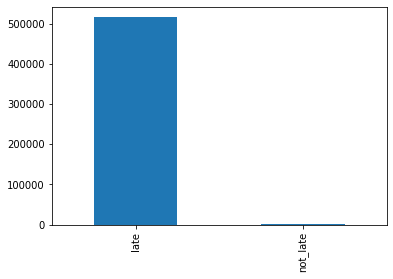

In [14]:
df_toTrain.late_flight.value_counts().plot(kind='bar')

In [15]:
df_toTrain.late_flight.value_counts()

late        516158
not_late      1544
Name: late_flight, dtype: int64

**NOTE** Looks like a pretty imbalance distribution of target variable.  Will probably need to use SMOTE and create synthetic data for the minority class.

## Corrleations

Text(0.5, 1, 'Correlation Heatmap')

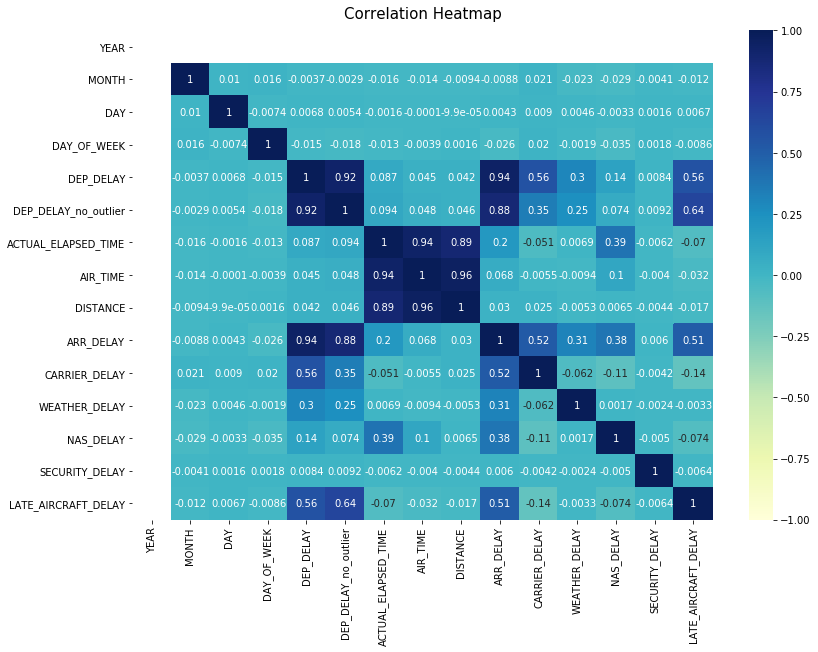

In [16]:
# increase figure size
plt.figure(figsize=(13, 9))
heatmap = sns.heatmap(df_toTrain.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu")

# define title
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12)

# ref. https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

**NOTE** Looks like high correlation between:
  - `DEP_DELAY_no_outlier` :: `ARR_DELAY`, which could makes logical sense because if you are late departing, then you are likely to be late arriving
  - `ACTUAL_ELAPSED_TIME` :: `DISTANCE` :: `AIR_TIME`, which make sense as each 3-variables are referencing same part of flight

# 3.) Train Model

In [17]:
# Download PyCaret
!pip install pycaret --quiet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


## a. Get the Data

In [18]:
data = df_toTrain.sample(frac=0.12, random_state=123)
data_unseen = df.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (56947, 22)
Unseen Data For Predictions: (7237702, 22)


## b. Setting Up Environment in PyCaret

In [19]:
from pycaret.classification import *
exp = setup(data = data, 
            numeric_features = ['YEAR', 'MONTH','DAY','DAY_OF_WEEK'],
            ignore_features = ['DEP_DELAY', 'ARR_DELAY', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME', 'ARR_TIME'],
            target = 'late_flight',
            fix_imbalance = True,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True,
            multicollinearity_threshold = 0.95,
            use_gpu = True,
            fold = 2
           )

,Description,Value
0,session_id,6387
1,Target,late_flight
2,Target Type,Binary
3,Label Encoded,"late: 0, not_late: 1"
4,Original Data,"(56947, 22)"
5,Missing Values,True
6,Numeric Features,11
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


## c. Comparing all models

In [20]:
# ref. 
#   -- https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=compare_models#pycaret.classification.compare_models
#   -- https://machinelearningmastery.com/k-fold-cross-validation/

best_model = compare_models(cross_validation=False)
# best_model = compare_modelfold=old=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9973,0.8366,0.0000,0.0000,0.0000,0.0000,0.0000,7.0100
et,Extra Trees Classifier,0.9970,0.6416,0.0000,0.0000,0.0000,-0.0006,-0.0010,9.8100
lightgbm,Light Gradient Boosting Machine,0.9967,0.9778,0.0000,0.0000,0.0000,-0.0010,-0.0013,2.1200
qda,Quadratic Discriminant Analysis,0.9958,0.5209,0.0435,0.0690,0.0533,0.0514,0.0527,1.9700
dt,Decision Tree Classifier,0.9943,0.5310,0.0652,0.0526,0.0583,0.0554,0.0558,8.2200
knn,K Neighbors Classifier,0.9863,0.5021,0.0217,0.0053,0.0085,0.0042,0.0053,12.1200
nb,Naive Bayes,0.9673,0.7993,0.6304,0.0509,0.0942,0.0896,0.1728,0.5000
ada,Ada Boost Classifier,0.9653,0.9753,0.7174,0.0538,0.1002,0.0956,0.1904,10.0500
gbc,Gradient Boosting Classifier,0.9622,0.9731,0.7391,0.0509,0.0952,0.0907,0.1877,44.2600
lr,Logistic Regression,0.9308,0.7183,0.2391,0.0095,0.0183,0.0132,0.0354,9.8800


# 4.) Create Model(s)

## a. Random Forest Classifier

In [21]:
rf = create_model('rf')
# rf = create_model('rf', cross_validation=False)

# trained model object is stored as `rf`
# print(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9974,0.8003,0.0189,1.0000,0.0370,0.0369,0.1372
1,0.9973,0.8694,0.0189,0.5000,0.0364,0.0362,0.0967
Mean,0.9974,0.8348,0.0189,0.7500,0.0367,0.0366,0.1170
SD,0.0000,0.0346,0.0000,0.2500,0.0003,0.0004,0.0202


## b. Ada Boost Classifier

In [22]:
ada = create_model('ada')
# ada = create_model('ada', cross_validation=False)

# trained model object is stored as `ada`
# print(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9852,0.9698,0.2264,0.0453,0.0755,0.0714,0.0961
1,0.9877,0.9743,0.2075,0.0514,0.0824,0.0785,0.0986
Mean,0.9865,0.9721,0.2170,0.0483,0.0789,0.0749,0.0973
SD,0.0012,0.0022,0.0094,0.0031,0.0035,0.0036,0.0013


## c. Light Gradient Boosting Machine

In [23]:
lightgbm = create_model('lightgbm')
# lightgbm = create_model('lightgbm', cross_validation=False)

# trained model object is stored as `lightgbm`
# print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9962,0.9748,0.0377,0.0741,0.0500,0.0483,0.0511
1,0.9971,0.9772,0.0377,0.2500,0.0656,0.0649,0.0962
Mean,0.9967,0.9760,0.0377,0.1620,0.0578,0.0566,0.0737
SD,0.0005,0.0012,0.0000,0.0880,0.0078,0.0083,0.0226


# 5.) Tune Model(s)

## a. Light Gradient Boosting Machine

In [24]:
tuned_lightgbm = tune_model(lightgbm, n_iter=2, early_stopping=True)

# tuned model object is stored as `tuned_lightgbm`
# print(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9969,0.9749,0.0377,0.1667,0.0615,0.0606,0.0782
1,0.9970,0.9820,0.0189,0.1111,0.0323,0.0315,0.0448
Mean,0.9970,0.9785,0.0283,0.1389,0.0469,0.0461,0.0615
SD,0.0000,0.0036,0.0094,0.0278,0.0146,0.0146,0.0167


# 6.) Models Performance

## a. Light Gradient Boosting Machine

### i. Confusion Matrix

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


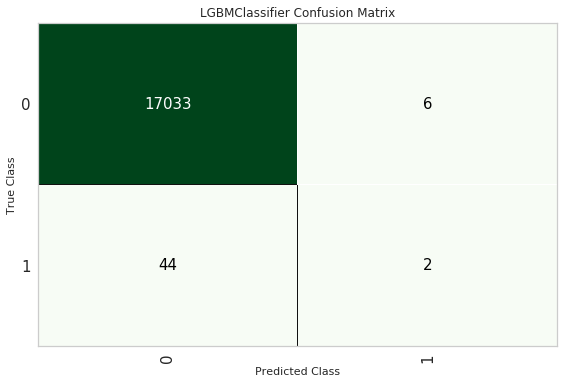

In [25]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

### ii. Features Importance

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


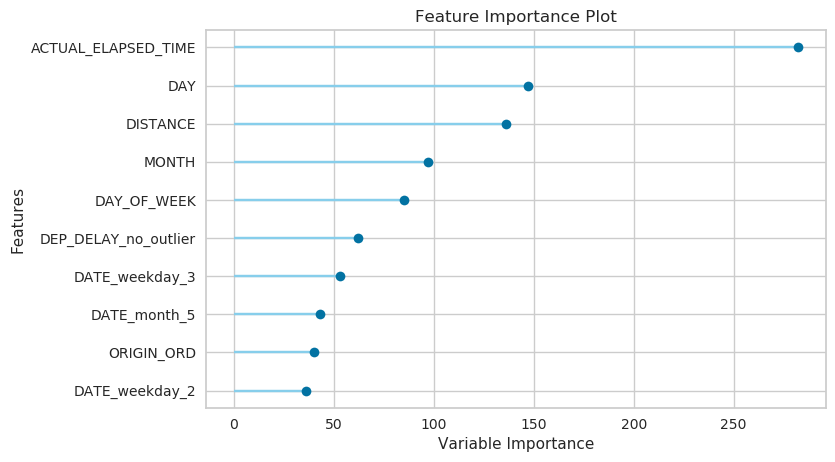

In [26]:
plot_model(tuned_lightgbm, plot='feature')

Features that has greatest explanatory power are:

* `ACTUAL_ELAPSED_TIME`
* `DAY` of the month

### iii. Intrepret Model's with SHAP

ref. 

* https://www.analyticsvidhya.com/blog/2020/05/pycaret-machine-learning-model-seconds/
* https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/?utm_source=blog&utm_medium=pycaret-machine-learning-model-seconds

In [27]:
!apt-get update && apt-get install -y build-essential -q
!python -m pip install -q shap

Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease
Hit:3 http://security.debian.org/debian-security buster/updates InRelease
Reading package lists... Done
Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.6).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


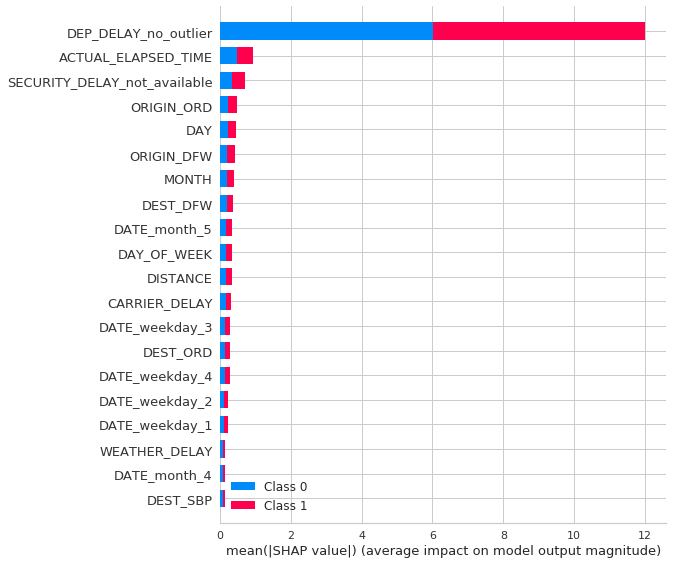

In [28]:
interpret_model(tuned_lightgbm, plot='summary')

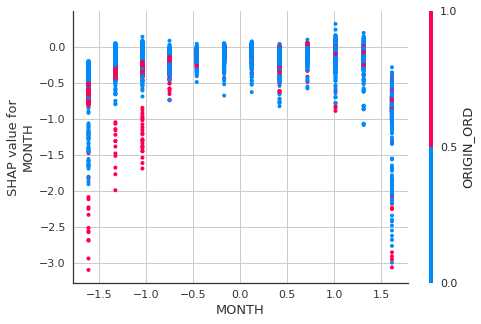

In [29]:
interpret_model(tuned_lightgbm, plot='correlation')

# 8.) Predict of Test Data Sample

## a. Light Gradient Boosting Machine

In [30]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9971,0.9807,0.0435,0.2500,0.0741,0.0733,0.1033


,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,...,DATE_weekday_2,DATE_weekday_3,DATE_weekday_4,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_1,DATE_is_month_start_0,late_flight,Label,Score
0,0.715765,-0.759234,1.515474,-1.959007,-0.368363,0.255318,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,1.0
1,-0.169454,0.600528,0.042790,-0.976600,-1.018689,-1.071676,0.303715,0.443553,0.231007,0.195886,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
2,0.418889,-1.557383,0.042790,-1.123707,1.420278,1.495640,0.303715,0.443553,0.231007,0.195886,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
3,1.014034,1.500835,-1.486837,-1.604332,-0.520990,0.008453,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
4,0.418889,-1.215001,1.515474,-0.701146,-0.560206,-1.201019,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17080,-1.611379,-1.557383,-0.971696,-0.115038,-0.639893,-0.817166,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
17081,-1.038269,-0.759234,0.539085,1.982376,0.859436,1.233523,-1.894699,-1.626037,-1.489155,3.735175,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,late,late,1.0
17082,-1.038269,0.261843,1.515474,-1.277264,-0.931703,-1.139318,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,1.0
17083,-0.750088,0.374819,0.042790,-0.332640,-1.335439,-0.965463,0.303715,0.443553,0.231007,0.195886,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0


# 9.) Deploy Model (finalized)

## a. Light Gradient Boosting Machine

In [31]:
final_lightgbm = finalize_model(tuned_lightgbm)

#Final model's parameters for deployment
print(final_lightgbm)

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=96, min_child_weight=0.001, min_split_gain=

**Caution**: Once the model is finalized using `finalize_model()`, the entire dataset including the test/hold-out set is used for training. As a result, if the model is used for predictions on the hold-out set after `finalize_model()` is used, the information grid printed will be misleading as you are trying to predict on the same data that was used for modeling.

In [32]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,MONTH,DAY,DAY_OF_WEEK,DEP_DELAY_no_outlier,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,LATE_AIRCRAFT_DELAY,...,DATE_weekday_2,DATE_weekday_3,DATE_weekday_4,DATE_weekday_5,DATE_weekday_6,DATE_is_month_end_1,DATE_is_month_start_0,late_flight,Label,Score
0,0.715765,-0.759234,1.515474,-1.959007,-0.368363,0.255318,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,1.0
1,-0.169454,0.600528,0.042790,-0.976600,-1.018689,-1.071676,0.303715,0.443553,0.231007,0.195886,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
2,0.418889,-1.557383,0.042790,-1.123707,1.420278,1.495640,0.303715,0.443553,0.231007,0.195886,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
3,1.014034,1.500835,-1.486837,-1.604332,-0.520990,0.008453,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
4,0.418889,-1.215001,1.515474,-0.701146,-0.560206,-1.201019,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17080,-1.611379,-1.557383,-0.971696,-0.115038,-0.639893,-0.817166,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0
17081,-1.038269,-0.759234,0.539085,1.982376,0.859436,1.233523,-1.894699,-1.626037,-1.489155,3.735175,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,late,late,1.0
17082,-1.038269,0.261843,1.515474,-1.277264,-0.931703,-1.139318,0.303715,0.443553,0.231007,0.195886,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,late,late,1.0
17083,-0.750088,0.374819,0.042790,-0.332640,-1.335439,-0.965463,0.303715,0.443553,0.231007,0.195886,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,late,late,1.0


# 10.) Predict on Unseen Dataset

In [ ]:
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions

In [ ]:
KPI = 'Accuracy'
from pycaret.utils import check_metric
# check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'])
check_metric(unseen_predictions['late_flight'], unseen_predictions['Label'], metric=KPI)

# 11.) Persist Model

In [33]:
today = datetime.datetime.now()
today_datetime = today.strftime("%d-%m-%Y %H:%M:%S")
pkl_filename = 'Final_model___' + 'lightgbm' + '___for_' + airline_to_run + '_' + today_datetime

save_model(final_lightgbm, pkl_filename)

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['DEP_DELAY', 'ARR_DELAY',
                                                        'AIR_TIME', 'ARR_TIME'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['YEAR', 'MONTH',
                                                           'DAY',
                                                           'DAY_OF_WEEK'],
                                       target='late_flight', time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy...
                                 colsample_bytree=1.0, feature_fraction=0.8,
                                 importance_type='split', learning_rate=0.3,
   